https://medium.com/tensorflow/deep-reinforcement-learning-playing-cartpole-through-asynchronous-advantage-actor-critic-a3c-7eab2eea5296

In [1]:
from tensorflow.python import keras
from tensorflow.python.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
#import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#tf.enable_eager_execution(config=config)

import zmq
import multiprocessing as mp
import time
import json

from MarkovDecisionProcess import NumpyEncoder

In [2]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

annot = np.array([
    [0.25, 0.25],
    [0.25, 0.75],
    [0.75, 0.25],
    [0.75, 0.75]
])

[0 0] [0]
[0 1] [1]
[1 0] [1]
[1 1] [0]



/home/nathan/.conda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


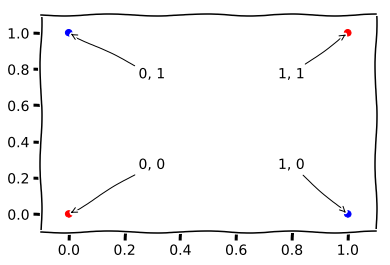

In [3]:
plt.xkcd()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

for x, y, a in zip(input_data, output_data, annot):
    print(x, y)
    plt.annotate("{}, {}".format(*x), xy=x, arrowprops=dict(arrowstyle='->'), xytext=a)
    color = 'b' if y else 'r'
    plt.plot(*x, color + 'o')
    
print()

In [4]:
class Classifier(keras.Model):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.dense = layers.Dense(100, activation='relu')
        self.probs = layers.Dense(output_size)

    def call(self, inputs):
        x = self.dense(inputs)
        return self.probs(x)

In [5]:
model = Classifier(2, 1)

In [6]:
tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
output = model(tensor)

In [7]:
output - output_data

<tf.Tensor: id=60, shape=(4, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.91784996],
       [-0.75520015],
       [ 0.32949334]], dtype=float32)>

In [8]:
grids = []

lin = np.linspace(0,1,21)
input_grid = []
for x in lin:
    for y in lin:
        input_grid.append([x, y])

lr = 0.1
losses = []
for i in range(100):
    tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
    with tf.GradientTape() as tape:
        output = model(tensor)
        loss = -tf.reduce_mean((output_data - output)**2)

    losses.append(loss.numpy())
    grads = tape.gradient(loss, model.trainable_weights)
    for w, g in zip(model.trainable_weights, grads):
        w.assign_add(lr*g)
    
    tensor = tf.convert_to_tensor(input_grid, dtype=tf.float32)
    output = model(tensor).numpy()
    grids.append(output)

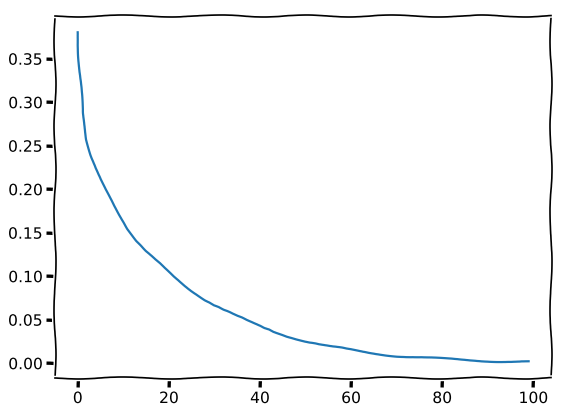

In [9]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.abs(losses))
plt.show()

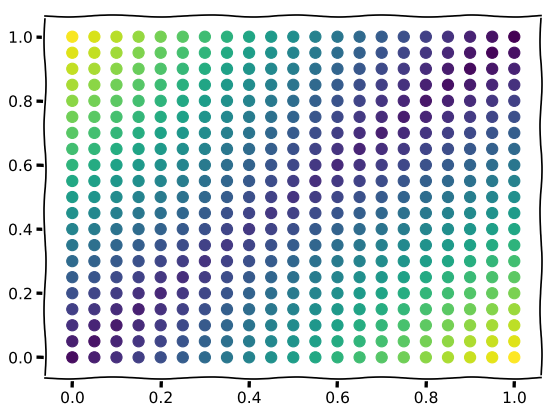

In [10]:
x1, x2 = np.split(np.array(input_grid), 2, axis=1)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x1, x2, 100*np.ones_like(y), c=grids[-1])
plt.show()

In [11]:
tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
output = model(tensor).numpy()

[0 0] [0.05892321]
[0 1] [0.96490884]
[1 0] [0.9730353]
[1 1] [0.02710926]



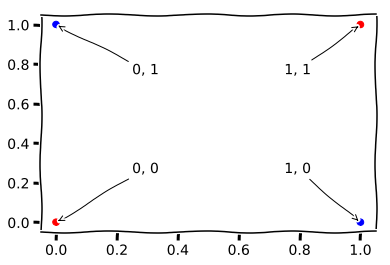

In [12]:
for x, y, a in zip(input_data, output, annot):
    print(x, y)
    plt.annotate("{}, {}".format(*x), xy=x, arrowprops=dict(arrowstyle='->'), xytext=a)
    color = 'b' if y > 0.5 else 'r'
    plt.plot(*x, color + 'o')
    
print()

# ZMQ Test

#### A Simple Test

In [14]:
def simple_test(name):
    np.random.seed(name)
    sleep_time = np.random.randint(0,5)
    print(name, sleep_time)
    time.sleep(sleep_time)
    print(name, "done!")

In [15]:
processes = [mp.Process(target=simple_test, args=(i,)) for i in range(4)]

In [16]:
for p in processes:
    p.start()

0 4
1 3
2 0
2 done!
3 2
3 done!
1 done!
0 done!


In [17]:
for p in processes:
    p.join()

#### Using ZMQ

In [18]:
def zmq_master(slave_count):
    header = "master >"
    context = zmq.Context()
    current_count = 0
    with context.socket(zmq.REP) as socket:
        socket.bind('tcp://127.0.0.1:5555')
        print(header, "listening for {} slaves...".format(slave_count))
        while True:
            msg = json.loads(socket.recv())
            print(header, "msg from {}".format(current_count))
            print(header, msg)
            socket.send_json({ "break": True})
            current_count += 1
            if current_count == slave_count:
                print(header, "breaking")
                break

In [19]:
def zmq_slave(name):
    header = "- {} >".format(name)
    context = zmq.Context()
    with context.socket(zmq.REQ) as socket:
        socket.connect('tcp://127.0.0.1:5555')
        socket.send_json({ "name": name })
        msg = json.loads(socket.recv())
        print(header, msg)
        if msg["break"]:
            print(header, "recieved break signal")

In [20]:
slave_count = 4
master = mp.Process(target=zmq_master, args=(slave_count,))
processes = [mp.Process(target=zmq_slave, args=(i,)) for i in range(slave_count)]

In [21]:
master.start()

master > listening for 4 slaves...
master > msg from 0
master > {'name': 0}
master > msg from 1
master > {'name': 1}
master > msg from 2
master > {'name': 2}
master > msg from 3
master > breaking
master > {'name': 3}


In [22]:
for p in processes:
    p.start()

- 0 > {'break': True}
- 0 > recieved break signal
- 1 > {'break': True}
- 1 > recieved break signal
- 3 > {'break': True}
- 2 > {'break': True}
- 3 > recieved break signal
- 2 > recieved break signal


In [23]:
master.join()
for p in processes:
    p.join()

#### Sending Complex Messages

In [82]:
master.join()
for p in processes:
    p.join()

In [83]:
def master_model():
    header = "master >"
    context = zmq.Context()
    with context.socket(zmq.REP) as socket:
        socket.bind('tcp://127.0.0.1:5555')
        print(header, 'listening...')
        while True:
            msg = json.loads(socket.recv())
            time.sleep(2)
            print(header, msg)
            if 'kill' in msg and msg['kill'] == True:
                print(header, "exiting")
                socket.send_string(json.dumps({ "exited": True, "name": "master" }, cls=NumpyEncoder))
                break
            socket.send_string(json.dumps({ "received": True, "data": np.random.rand(2,3)}, cls=NumpyEncoder))

In [84]:
def slave_model(name):
    header = "- {} >".format(name)
    context = zmq.Context()
    with context.socket(zmq.REQ) as socket:
        socket.connect('tcp://127.0.0.1:5555')
        socket.send_string(json.dumps({ "name": name }, cls=NumpyEncoder))
        msg = json.loads(socket.recv())
        print(header, msg)

In [85]:
slave_count = 4
master = mp.Process(target=master_model)
processes = [mp.Process(target=slave_model, args=(i,)) for i in range(slave_count)]

In [86]:
master.start()

master > listening...
master > {'name': 0}
master > {'name': 3}
master > {'name': 1}
master > {'name': 2}
master > {'kill': True}
master > exiting


In [87]:
for p in processes:
    p.start()

- 0 > {'received': True, 'data': [[0.5221438038603549, 0.8741229944189931, 0.5936073021210436], [0.4016018892774972, 0.48631454117641526, 0.3794888223869214]]}
- 3 > {'received': True, 'data': [[0.253963039647639, 0.5169542835916211, 0.4825478891031151], [0.9909792792540908, 0.8045524634284915, 0.9325872526894352]]}
- 1 > {'received': True, 'data': [[0.060438414824824815, 0.9112213709919719, 0.4151212091604183], [0.4873138229051669, 0.2979829684546622, 0.08356257035669534]]}
- 2 > {'received': True, 'data': [[0.1721528515964198, 0.41527873727917963, 0.6976162900740822], [0.29001453494994556, 0.8938609725319917, 0.4439470216900613]]}


In [88]:
context = zmq.Context()
with context.socket(zmq.REQ) as socket:
    socket.connect('tcp://127.0.0.1:5555')
    socket.send_json({ "kill": True })
    msg = json.loads(socket.recv())
    print(msg)

{'exited': True, 'name': 'master'}


In [89]:
master.join()
for p in processes:
    p.join()

#### Incorporating Tensorflow

In [11]:
master.join()
for p in processes:
    p.join()

In [49]:
def start_master():
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.enable_eager_execution(config=config)

    header = "master >"
    context = zmq.Context()
    model = Classifier(2, 1)
    losses = []

    def get_loss(model):
        tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
        output = model(tensor)
        loss = -tf.reduce_mean((output_data - output)**2)
        return np.abs(loss.numpy())
        
    def apply_grads(model, grads):
        for w, g in zip(model.trainable_weights, grads):
            w.assign_add(g)

    with context.socket(zmq.REP) as socket:
        socket.bind('tcp://127.0.0.1:5555')
        print(header, 'listening...')
        try:
            count = 0
            while True:
                msg = json.loads(socket.recv())
                socket.send_string(json.dumps({ "weights": model.get_weights()}, cls=NumpyEncoder))
                apply_grads(model, msg['grads'])
                loss = get_loss(model)
                losses.append(loss)
                count += 1
                if count % 100 == 0:
                    print("{} {:03d} {}".format(header, count, loss))
        except KeyboardInterrupt as e:
            print(header, 'Stopped.')
            plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
            plt.plot(np.abs(losses))
            plt.show()

In [50]:
def start_worker(input_data, output_data):
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.enable_eager_execution(config=config)

    header = "- {} >".format(input_data)
    context = zmq.Context()
    
    model = Classifier(2, 1)
    losses = []
    lr = 0.01
    input_data = input_data
    output_data = output_data
    tensor = tf.convert_to_tensor(np.array([input_data]), dtype=tf.float32)
    
    def get_grads(model, tensor):
        with tf.GradientTape() as tape:
            output = model(tensor)
            loss = -tf.reduce_mean((output_data - output)**2)
        losses.append(loss.numpy())
        grads = tape.gradient(loss, model.trainable_weights)
        return [lr*g.numpy() for g in grads]
    
    try:
        for i in range(100):
            with context.socket(zmq.REQ) as socket:
                socket.connect('tcp://127.0.0.1:5555')
                grads = get_grads(model, tensor)
                socket.send_string(json.dumps({ "grads": grads, "data": input_data }, cls=NumpyEncoder))
                msg = json.loads(socket.recv())
                model.set_weights(msg['weights'])
    except KeyboardInterrupt as e:
        print(header, 'Stopped.')

In [51]:
slave_count = 4
master = mp.Process(target=start_master)
processes = [mp.Process(target=start_worker, args=(input_data[i], output_data[i])) for i in range(slave_count)]

master > listening...
master > 100 0.1628258377313614
master > 200 0.10720884799957275
master > 300 0.06913335621356964
master > 400 0.043979838490486145
master > Stopped.


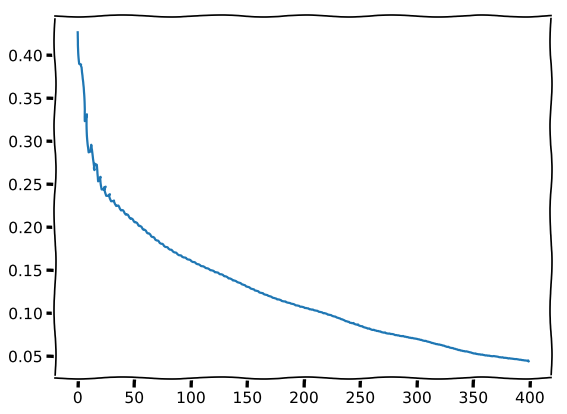

In [52]:
master.start()

In [53]:
for p in processes:
    p.start()

In [43]:
master.join()
for p in processes:
    p.join()